In [ ]:
#@title
!unzip /content/drive/MyDrive/Dataset.zip

# Problem Statement

Specific Test III. Image Super-resolution
Task III.A: Train a deep learning-based super resolution algorithm of your choice to upscale low-resolution strong lensing images using the provided high-resolution samples as ground truths. Please implement your approach in PyTorch or Keras and discuss your strategy.
Dataset: https://drive.google.com/file/d/1uJmDZw649XS-r-dYs9WD-OPwF_TIroVw/view?usp=sharing
Dataset Description: The dataset comprises simulated strong lensing images with no substructure at multiple resolutions: high-resolution (HR) and low-resolution (LR).
Evaluation Metrics: MSE (Mean Squared Error), SSIM (Structural Similarity Index), PSNR (Peak Signal-to-Noise Ratio)
Task III.B: Train a deep learning-based super-resolution algorithm of your choice to enhance low-resolution strong lensing images using a limited dataset of real HR/LR pairs collected from HSC and HST telescopes. You can adapt and fine-tune your super-resolution model from Task III.A. or use any other approach, such as few-shot learning strategies, transfer learning, domain adaptation, or data augmentation techniques, etc. Please implement your approach in PyTorch or Keras and discuss your strategy.
Dataset: https://drive.google.com/file/d/1plYfM-jFJT7TbTMVssuCCFvLzGdxMQ4h/view?usp=sharing
Dataset Description: The dataset comprises 300 strong lensing image pairs at multiple resolutions: high-resolution (HR) and low-resolution (LR).
Evaluation Metrics: MSE (Mean Squared Error), SSIM (Structural Similarity Index), PSNR (Peak Signal-to-Noise Ratio)

In this notebook I will try to train a RCAN model for the super resolution task. Then I will try to adopt it for the real world images that are provided.

## Task III.A

Importing libraries


In [2]:

import numpy as np
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Creating the Dataset Class

In [3]:
class SuperResolutionDataset(torch.utils.data.Dataset):


    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lr_images = os.listdir(lr_dir)
        self.hr_images = os.listdir(hr_dir)
        self.transform = transform

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_img_name = os.path.join(self.lr_dir, self.lr_images[idx])
        hr_img_name = os.path.join(self.hr_dir, self.hr_images[idx])
        lr_image = np.load(lr_img_name)
        hr_image = np.load(hr_img_name)
        if lr_image.ndim == 2: lr_image = np.expand_dims(lr_image, axis=-1)
        if hr_image.ndim == 2: hr_image = np.expand_dims(hr_image, axis=-1)
        sample = {'lr': lr_image, 'hr': hr_image}
        if self.transform: sample = self.transform(sample)
        return sample


Functions for transformation and Augmentation

In [4]:
class ToTensor(object):

    def __call__(self, sample):
        lr, hr = sample['lr'], sample['hr']


        if lr.ndim == 3:
            lr = np.squeeze(lr)
        if hr.ndim == 3:
            hr = np.squeeze(hr)

        if lr.ndim == 2:
            lr = np.expand_dims(lr, axis=0)
        if hr.ndim == 2:
            hr = np.expand_dims(hr, axis=0)


        lr_tensor = torch.from_numpy(lr).float()
        hr_tensor = torch.from_numpy(hr).float()

        return {'lr': lr_tensor, 'hr': hr_tensor}


In [5]:

class RandomFlipAndRotation(object):

    def __call__(self, sample):
        lr, hr = sample['lr'], sample['hr']
        if lr.ndim == 2:
            lr = lr[:, :, None]
        if hr.ndim == 2:
            hr = hr[:, :, None]


        if np.random.rand() > 0.5:
            lr = np.fliplr(lr).copy()
            hr = np.fliplr(hr).copy()


        if np.random.rand() > 0.5:
            lr = np.flipud(lr).copy()
            hr = np.flipud(hr).copy()


        rotations = np.random.choice([0, 90, 180, 270])
        lr = np.rot90(lr, k=rotations // 90).copy()
        hr = np.rot90(hr, k=rotations // 90).copy()



        return {'lr': lr, 'hr': hr}


In [6]:

lr_dir = '/content/Dataset/LR'
hr_dir = '/content/Dataset/HR'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:

transformed_dataset = SuperResolutionDataset(lr_dir=lr_dir, hr_dir=hr_dir,
                                             transform=transforms.Compose([
                                                RandomFlipAndRotation(),
                                                ToTensor()
                                             ]))


Creating the Training and Validation Datasets

In [8]:

total_size = len(transformed_dataset)
train_size = int(0.9 * total_size)
validation_size = total_size - train_size


train_dataset, validation_dataset = random_split(transformed_dataset, [train_size, validation_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Creating the components of the model

In [9]:
class ChannelAttention(nn.Module):
    def __init__(self, num_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(num_channels, num_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(num_channels // reduction_ratio, num_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResidualChannelAttentionBlock(nn.Module):
    def __init__(self, num_channels, reduction_ratio=16):
        super(ResidualChannelAttentionBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, bias=False)
        self.ca = ChannelAttention(num_channels, reduction_ratio)

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        out = self.ca(out)
        return out + residual

class ResidualGroup(nn.Module):
    def __init__(self, num_channels, reduction_ratio=16, num_blocks=5):
        super(ResidualGroup, self).__init__()
        blocks = [ResidualChannelAttentionBlock(num_channels, reduction_ratio) for _ in range(num_blocks)]
        self.group = nn.Sequential(*blocks, nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, bias=False))

    def forward(self, x):
        return self.group(x) + x

class Upsample(nn.Module):
    def __init__(self, in_channels, scale_factor=2):
        super(Upsample, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * (scale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.relu(x)
        return x

class RCAN(nn.Module):
    def __init__(self, num_channels=1, num_features=64, reduction_ratio=16, num_res_groups=10, num_res_blocks=5, scale_factor=2):
        super(RCAN, self).__init__()
        self.conv_first = nn.Conv2d(num_channels, num_features, kernel_size=9, padding=4, bias=False)
        self.res_groups = nn.Sequential(*[ResidualGroup(num_features, reduction_ratio, num_res_blocks) for _ in range(num_res_groups)])
        self.upsample = Upsample(num_features, scale_factor=scale_factor)  # Add an upsampling layer
        self.conv_last = nn.Conv2d(num_features, num_channels, kernel_size=9, padding=4, bias=False)

    def forward(self, x):
        x = self.conv_first(x)
        x = self.res_groups(x)
        x = self.upsample(x)
        x = self.conv_last(x)
        return x



In [10]:
model = RCAN()

Functions for calculate metrics and train a model

In [11]:

def calculate_metrics(output, target, data_range=255):
    batch_size = output.shape[0]
    ssim_total = 0.0
    psnr_total = 0.0

    for i in range(batch_size):
        output_img = output[i]
        target_img = target[i]

        ssim_total += compare_ssim(output_img, target_img, data_range=data_range)
        psnr_total += compare_psnr(output_img, target_img, data_range=data_range)

    return ssim_total / batch_size, psnr_total / batch_size

def train_model():

    model = RCAN().to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    best_validation_loss = float('inf')

    for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            ssim_list = []
            psnr_list = []
            for batch in tqdm(train_dataloader):
                inputs, labels = batch['lr'].to(device), batch['hr'].to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()


                outputs_squeezed = outputs.squeeze().cpu().detach()


                if torch.isnan(outputs_squeezed).any() or torch.isinf(outputs_squeezed).any():

                    outputs_squeezed[torch.isnan(outputs_squeezed)] = 0  # Replace NaN with 0
                    outputs_squeezed[torch.isinf(outputs_squeezed)] = 0  # Replace inf with 0


                outputs_clamped = torch.clamp(outputs_squeezed, 0, 1)

                output_np = (outputs_clamped.numpy() * 255).astype(np.uint8)
                target_np = (labels.squeeze().cpu().detach().numpy() * 255).astype(np.uint8)



                ssim, psnr = calculate_metrics(output_np, target_np)
                ssim_list.append(ssim)
                psnr_list.append(psnr)

            epoch_loss = running_loss / len(train_dataloader)
            print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}, Avg SSIM: {np.mean(ssim_list):.4f}, Avg PSNR: {np.mean(psnr_list):.4f}")
            np.savez("training_metrics.npz", ssim=np.array(ssim_list), psnr=np.array(psnr_list), loss=np.array(loss_list))

            model.eval()
            validation_loss = 0.0
            val_ssim_list = []
            val_psnr_list = []
            with torch.no_grad():
                for batch in tqdm(validation_dataloader):
                    inputs, labels = batch['lr'].to(device), batch['hr'].to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    validation_loss += loss.item()


                    outputs_np = outputs.squeeze().cpu().numpy() * 255.0
                    labels_np = labels.squeeze().cpu().numpy() * 255.0


                    outputs_np = np.clip(outputs_np, 0, 255).astype("uint8")
                    labels_np = np.clip(labels_np, 0, 255).astype("uint8")

                    for i in range(outputs_np.shape[0]):
                        ssim = compare_ssim(outputs_np[i], labels_np[i], data_range=255)
                        psnr = compare_psnr(outputs_np[i], labels_np[i], data_range=255)
                        val_ssim_list.append(ssim)
                        val_psnr_list.append(psnr)

            avg_val_ssim = np.mean(val_ssim_list)
            avg_val_psnr = np.mean(val_psnr_list)
            validation_loss /= len(validation_dataloader)
            np.savez("training_metrics.npz", ssim=np.array(avg_val_ssim), psnr=np.array(avg_val_psnr), loss=np.array(loss_list))
            print(f'Epoch {epoch+1}, Validation Loss: {validation_loss:.4f}, Avg SSIM: {avg_val_ssim:.4f}, Avg PSNR: {avg_val_psnr:.4f}')

            if validation_loss < best_validation_loss:
                best_validation_loss = validation_loss
                torch.save(model.state_dict(), f"best_model_epoch_{epoch+1}.pth")
                print(f"Best model saved as best_model_epoch_{epoch+1}.pth")


We wil be using the MSE loss and the Adam optimizer

In [12]:





model.to(device)


criterion = nn.MSELoss()


optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 5


In [13]:
ssim_list = []
psnr_list = []
loss_list = []

best_validation_loss = float('inf')

We train the model here. I have trained the model using the same code on a python script instead of a Jupyter Notebook hence there are no outputs. I have uploaded the best trained model to be evaluated

In [ ]:



train_model()

In [14]:
model = RCAN()
model = RCAN().to(device)
model.load_state_dict(torch.load('/content/best_model_epoch_35.pth', map_location=device))
model.eval()

RCAN(
  (conv_first): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
  (res_groups): Sequential(
    (0): ResidualGroup(
      (group): Sequential(
        (0): ResidualChannelAttentionBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (ca): ChannelAttention(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (fc): Sequential(
              (0): Linear(in_features=64, out_features=4, bias=False)
              (1): ReLU(inplace=True)
              (2): Linear(in_features=4, out_features=64, bias=False)
              (3): Sigmoid()
            )
          )
        )
        (1): ResidualChannelAttentionBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (relu): ReLU(inplace=True)
     

Function to test the tr5ained model and view sample outputs

In [15]:
def display_images(lr, hr, sr, index):
    plt.figure(figsize=(10, 4))
    titles = ['Low Resolution', 'High Resolution', 'Super Resolution']
    images = [lr, hr, sr]
    for i, image in enumerate(images):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])
        plt.imshow(image.squeeze(), cmap='gray')
        plt.axis('off')
    plt.savefig(f"comparison_new_{index}.png")
    plt.show()


Evaluating the model on the validation datset

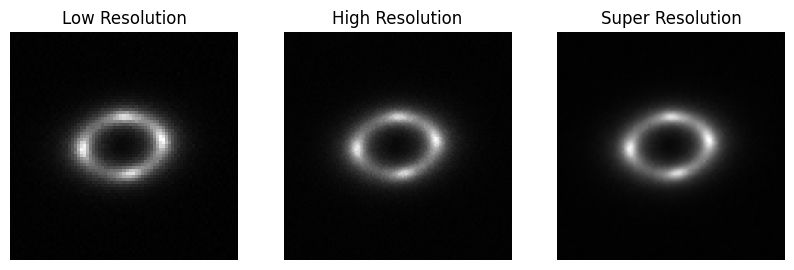

SSIM:0.9635363566224785 PSNR:43.99928220200474


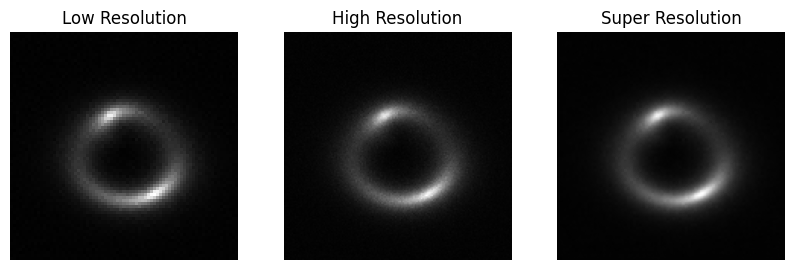

SSIM:0.9562397155110142 PSNR:43.14700738734632


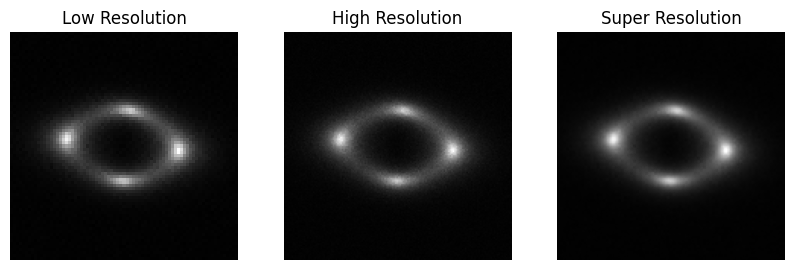

SSIM:0.9590447047428806 PSNR:43.75177617828328


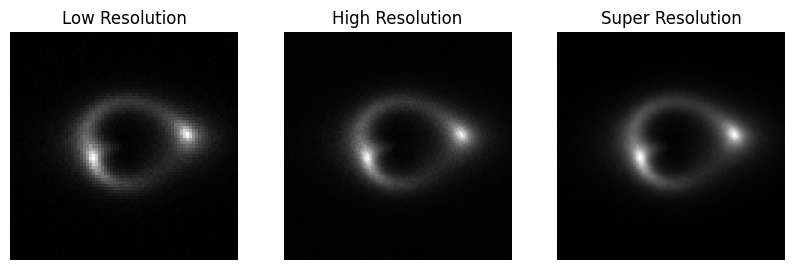

SSIM:0.9626013384881525 PSNR:44.165881800764446


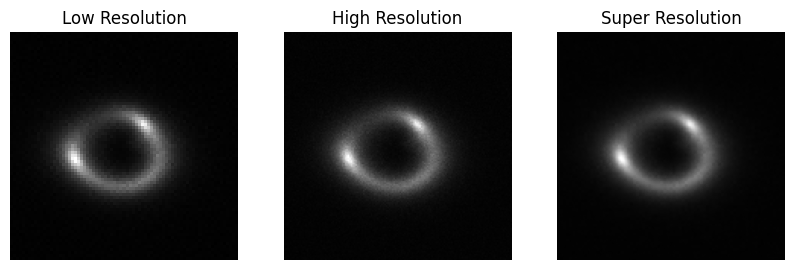

SSIM:0.9609600287758411 PSNR:43.58408613204413


In [16]:
with torch.no_grad():
    for i, batch in enumerate(validation_dataloader):
        inputs, labels = batch['lr'].to(device), batch['hr'].to(device)
        outputs = model(inputs)

        outputs_np = outputs.squeeze().cpu().numpy() * 255.0
        labels_np = labels.squeeze().cpu().numpy() * 255.0


        outputs_np = np.clip(outputs_np, 0, 255).astype("uint8")
        labels_np = np.clip(labels_np, 0, 255).astype("uint8")

        lr_img = inputs.squeeze().cpu().numpy()
        hr_img = labels.squeeze().cpu().numpy()
        sr_img = outputs.squeeze().cpu().numpy()

        display_images(lr_img, hr_img, sr_img, i)
        ssim, psnr = calculate_metrics(outputs_np, labels_np)
        print(f"SSIM:{ssim} PSNR:{psnr}")


        if i == 4:
            break

## Task III.B

Here we have to fine-tune the model to different images. Due to lack of time on my end I wasn't able to properly fine tune the model or use another domain adoption methods. I just trained the model with the newer images which did not give acceptable results. I will attempt fine-tuning after submission as well if possible.

In [ ]:
!unzip /content/drive/MyDrive/Dataset_3B.zip -d /content/NEW_DATASET

In [18]:
model_path= '/content/best_model_epoch_35.pth'

model = RCAN()
model = RCAN().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))


<All keys matched successfully>

In [19]:

def train_model():
    # Model instantiation, optimizer setup, etc.

    model = RCAN().to(device)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # Assuming you've defined train_dataloader and validation_dataloader

    best_validation_loss = float('inf')

    for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            ssim_list = []
            psnr_list = []
            for batch in tqdm(train_dataloader):
                inputs, labels = batch['lr'].to(device), batch['hr'].to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Optionally calculate SSIM and PSNR for the current batch and store them
                # Assuming 'output' and 'target' are PyTorch tensors in the range [0, 1]
                output_np = (outputs.squeeze().cpu().detach().numpy() * 255).astype(np.uint8)
                target_np = (labels.squeeze().cpu().detach().numpy() * 255).astype(np.uint8)



                ssim, psnr = calculate_metrics(output_np, target_np)
                ssim_list.append(ssim)
                psnr_list.append(psnr)

            # Training statistics for the epoch
            epoch_loss = running_loss / len(train_dataloader)
            print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}, Avg SSIM: {np.mean(ssim_list):.4f}, Avg PSNR: {np.mean(psnr_list):.4f}")

            # Validation phase
            model.eval()
            validation_loss = 0.0
            with torch.no_grad():
                for batch in tqdm(validation_dataloader):
                    inputs, labels = batch['lr'].to(device), batch['hr'].to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    validation_loss += loss.item()

            validation_loss /= len(validation_dataloader)
            print(f'Epoch {epoch+1}, Validation Loss: {validation_loss:.4f}')

            # Save model if validation loss improved
            if validation_loss < best_validation_loss:
                best_validation_loss = validation_loss
                torch.save(model.state_dict(), f"new_best_model_epoch_{epoch+1}.pth")
                print(f"Best model saved as best_model_epoch_{epoch+1}.pth")
            pass





In [21]:

lr_dir = '/content/NEW_DATASET/Dataset/LR'
hr_dir = '/content/NEW_DATASET/Dataset/HR'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:

transformed_dataset = SuperResolutionDataset(lr_dir=lr_dir, hr_dir=hr_dir,
                                             transform=transforms.Compose([
                                                RandomFlipAndRotation(),
                                                ToTensor()
                                             ]))

In [ ]:

ssim_list = []
psnr_list = []
loss_list = []

best_validation_loss = float('inf')  # Initialize with a very high value




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset preparation, including train-validation split
total_size = len(transformed_dataset)
train_size = int(0.9 * total_size)
validation_size = total_size - train_size
train_dataset, validation_dataset = random_split(transformed_dataset, [train_size, validation_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False, num_workers=4)

train_model()

In [27]:
model = RCAN()
model = RCAN().to(device)
model.load_state_dict(torch.load('/content/new_best_model_epoch_96.pth', map_location=device))
model.eval()

RCAN(
  (conv_first): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
  (res_groups): Sequential(
    (0): ResidualGroup(
      (group): Sequential(
        (0): ResidualChannelAttentionBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (ca): ChannelAttention(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (fc): Sequential(
              (0): Linear(in_features=64, out_features=4, bias=False)
              (1): ReLU(inplace=True)
              (2): Linear(in_features=4, out_features=64, bias=False)
              (3): Sigmoid()
            )
          )
        )
        (1): ResidualChannelAttentionBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (relu): ReLU(inplace=True)
     

Here's the output for the newer model. As we can see its performance is not acceptable due to improper fine tuning. As I have to submit before the deadline I cannot use another method but I will  try to do it after submission

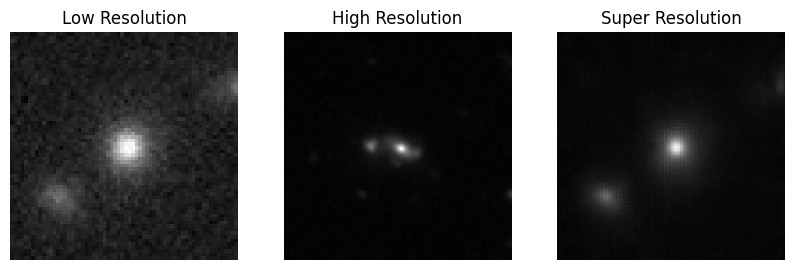

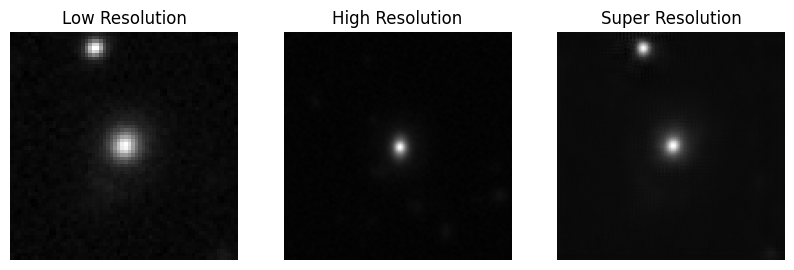

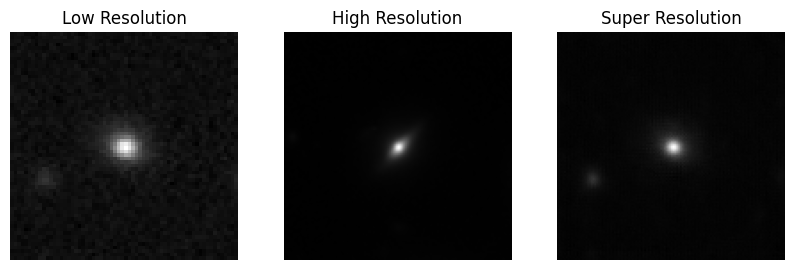

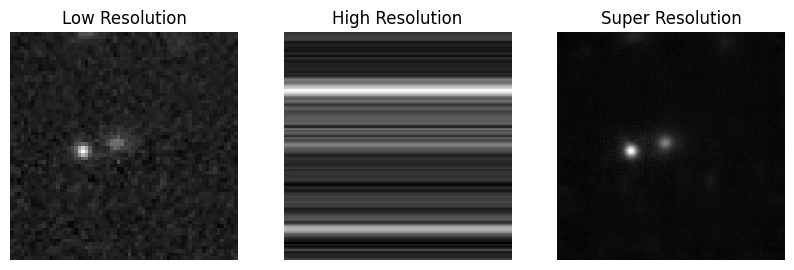

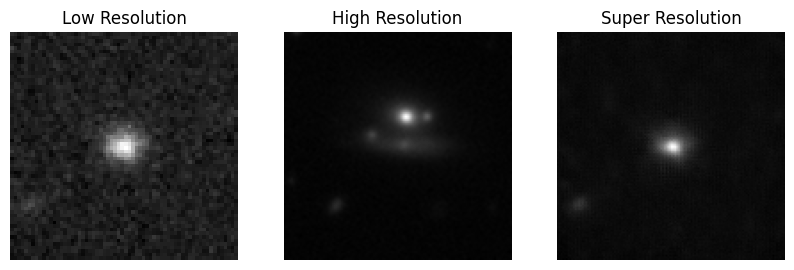

In [28]:
with torch.no_grad():
    for i, batch in enumerate(validation_dataloader):
        inputs, labels = batch['lr'].to(device), batch['hr'].to(device)
        outputs = model(inputs)

        lr_img = inputs.squeeze().cpu().numpy()
        hr_img = labels.squeeze().cpu().numpy()
        sr_img = outputs.squeeze().cpu().numpy()

        display_images(lr_img, hr_img, sr_img, i)

        if i == 4:
            break